'''

Setup Info 

conda create -n news_stock  python=3.7 anaconda


activate news_stock



pip install xgboost



Data Info :

Added sentiment values to csv using  jupyter notebook
Extracting the sentiment values for the news headlines and saving to CSV File

Added start trend by comparing current days opening value with previous days adjecent close value

combined with sentiment.csv


Credits :   

Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. 
Retrieved 03/25/2019  from https://www.kaggle.com/aaron7sun/stocknews

https://www.kaggle.com/lseiyjg/use-news-to-predict-stock-markets

http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html


'''



In [5]:
#Importing all the modules need 
import nltk
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from scipy import sparse
from scipy.sparse import issparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
#CSV created through program
data = pd.read_csv("combined with sentiment.csv")

In [7]:
data.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8',
       ...
       'Top23 neutral', 'Top23 negative', 'Top24 CompoundValue',
       'Top24 positive', 'Top24 neutral', 'Top24 negative',
       'Top25 CompoundValue', 'Top25 positive', 'Top25 neutral',
       'Top25 negative'],
      dtype='object', length=128)

In [8]:
data.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top23 neutral,Top23 negative,Top24 CompoundValue,Top24 positive,Top24 neutral,Top24 negative,Top25 CompoundValue,Top25 positive,Top25 neutral,Top25 negative
0,8/8/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,0.860,0.140,-0.8519,0.000,0.350,0.650,0.4019,0.351,0.649,0.0
1,8/11/2008,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,0.753,0.247,-0.1832,0.263,0.414,0.323,0.0000,0.000,1.000,0.0


In [9]:
#Combined CSV file with stock price data and top 25 news headlines data for each date
news = pd.read_csv('Combined_News_DJIA.csv')

Frequency Analysis - calculate the relative frequency of occurrence of each word

In [11]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arupatil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
# Create a single string for each date (since we only want to look at word counts)
combined_news = ''
for row in range(0,len(news.index)):
    combined_news+=' '.join(str(x).lower().strip() for x in news.iloc[row,2:27])
vectorizer = CountVectorizer()
news_vect = vectorizer.build_tokenizer()(combined_news)
word_counts = pd.DataFrame([[x,news_vect.count(x)] for x in set(news_vect)], columns = ['Word', 'Count'])


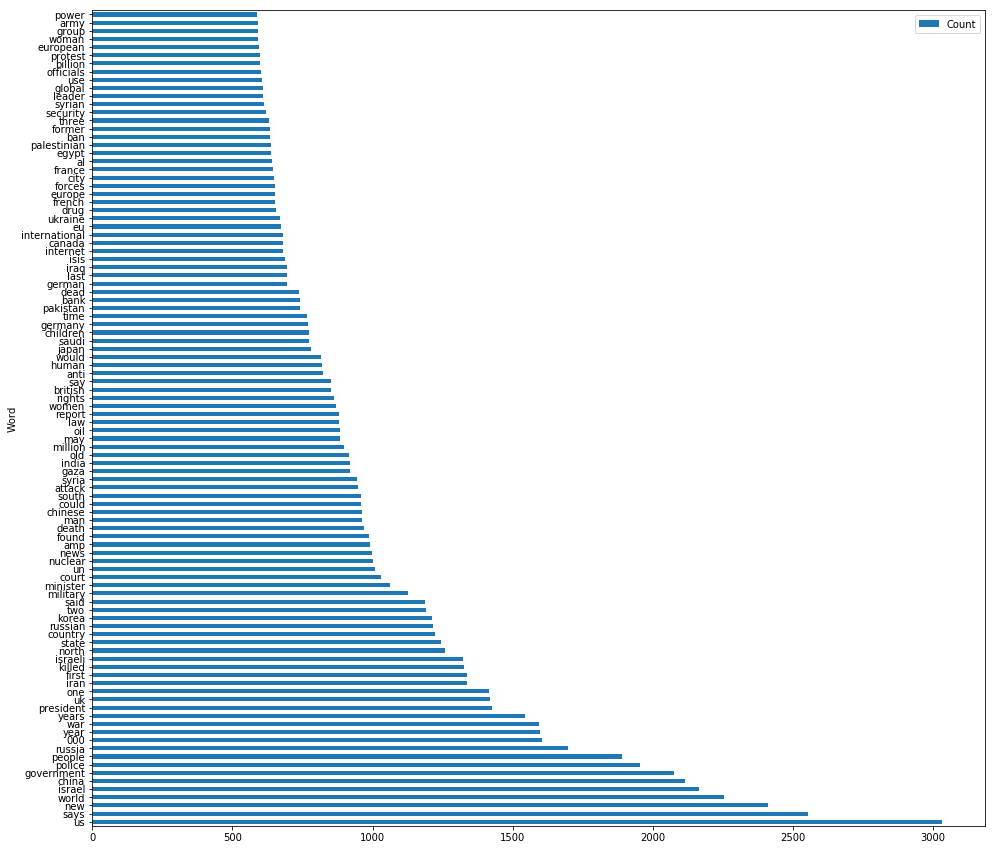

In [13]:
word_counts_adj = word_counts
word_counts_adj = word_counts_adj.reset_index(drop=True)

for i in word_counts['Word']:
    if i in stop:
        word_counts_adj = word_counts_adj.drop(word_counts_adj[word_counts_adj['Word'] == i].index)
        
word_counts_adj.index = word_counts_adj['Word']
counts = word_counts_adj.sort_values(by='Count', ascending=False)[0:100].plot(kind='barh', figsize = (16,15))
plt.show()

1591


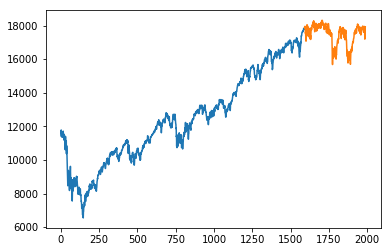

In [14]:
#Below plot shows the opening price split up into the respective train and test sets.

stock = pd.read_csv("DJIA_table_with_start.csv")
train_size = int(len(stock.index) * 0.8)

print(train_size)
train = stock.iloc[:train_size]
test = stock.iloc[train_size:]

plt.plot(train['Open'])
plt.plot([None for i in train['Open']] + [x for x in test['Open']])

In [15]:
# In this predictors set, we have considered only all top 25 headlines compound values.
PredictorCols1=['Top1 CompoundValue', 'Top2 CompoundValue', 'Top3 CompoundValue',
                      'Top4 CompoundValue', 'Top5 CompoundValue','Top6 CompoundValue', 'Top7 CompoundValue',
                      'Top8 CompoundValue', 'Top9 CompoundValue','Top10 CompoundValue', 'Top11 CompoundValue',
                      'Top12 CompoundValue', 'Top13 CompoundValue','Top14 CompoundValue', 'Top15 CompoundValue',
                     'Top16 CompoundValue', 'Top17 CompoundValue','Top18 CompoundValue', 'Top19 CompoundValue',
                      'Top20 CompoundValue', 'Top21 CompoundValue','Top22 CompoundValue', 'Top23 CompoundValue',
                      'Top24 CompoundValue', 'Top25 CompoundValue']

# In this predictors set, we have considered only all top 25 headlines positive values.
PredictorCols2=['Top1 positive', 'Top2 positive','Top3 positive',
                      'Top4 positive', 'Top5 positive','Top6 positive', 'Top7 positive',
                      'Top8 positive', 'Top9 positive','Top10 positive', 'Top11 positive',
                      'Top12 positive', 'Top13 positive','Top14 positive', 'Top15 positive',
                     'Top16 positive', 'Top17 positive','Top18 positive', 'Top19 positive',
                      'Top20 positive', 'Top21 positive','Top22 positive', 'Top23 positive',
                      'Top24 positive', 'Top25 positive']

# In this predictors set, we have considered only all top 25 headlines negative values.
PredictorCols3=['Top1 negative', 'Top2 negative','Top3 negative', 
                      'Top4 negative', 'Top5 negative','Top6 negative', 'Top7 negative',
                      'Top8 negative', 'Top9 negative','Top10 negative', 'Top11 negative',
                      'Top12 negative', 'Top13 negative','Top14 negative', 'Top15 negative',
                     'Top16 negative', 'Top17 negative','Top18 negative', 'Top19 negative',
                      'Top20 negative', 'Top21 negative','Top22 negative', 'Top23 negative',
                      'Top24 negative', 'Top25 negative']

In [16]:
#Creating different models to predict the stock movement using the sentiment score and the start trend
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier, SGDRegressor,LogisticRegression

#Function which takes the input parameters : data_to_model = the predictor columns to be considered in the prediction.
#                                             train = train data 
#                                             test = test data
# This function passes the train data to various machine learning models and gives accuracy as output.
def models(data_to_model,train,test):
    num_folds = 10
    scoring = 'accuracy'
    # Append the models to the models list
    models = []
    models.append(('LR' , LogisticRegression(solver='lbfgs')))
   
    models.append(('KNN' , KNeighborsClassifier()))
    models.append(('Decision TreeClassifier' , DecisionTreeClassifier()))
    models.append(('Gaussian Naive Bayes' , GaussianNB()))
    models.append(('SVM' , SVC(gamma='auto')))
    models.append(('Random Forest' , RandomForestClassifier(n_estimators=50)))
    models.append(('XGBoost',XGBClassifier()))
    '''models.append(('XGBoost after tuning ',XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=25)))'''
    for name, model in models:
        clf = model
        clf.fit(train[data_to_model], train["Label"])
        y_pred = clf.predict(test[data_to_model])
        accu_score = accuracy_score(test["Label"], y_pred)
        print(name,accu_score*100)


Taking data from  2008-08-08 to 2014-12-31 as train and
2015-01-01 to 2016-07-01 as test

In [17]:
#Model with the compound values of sentiment
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']
print("Accuracy with compound sentiment values")
# PredictorCols1 is for compound values of sentiment
data_to_model=PredictorCols1
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and compound sentiment values")
models(data_to_model,train,test)

Accuracy with compound sentiment values
LR 51.20068610634648
KNN 50.17152658662093
Decision TreeClassifier 50.34305317324185
Gaussian Naive Bayes 50.08576329331046
SVM 53.087478559176674
Random Forest 52.744425385934825
XGBoost 51.02915951972555


Accuracy with start trend and compound sentiment values
LR 59.86277873070326
KNN 53.00171526586621
Decision TreeClassifier 54.373927958833626
Gaussian Naive Bayes 61.492281303602056
SVM 62.17838765008577
Random Forest 56.861063464837045
XGBoost 57.20411663807891


In [18]:
#Model with the positive values of sentiment
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']
print("Accuracy with positive sentiment")
# PredictorCols1 is for positive values of sentiment
data_to_model=PredictorCols2
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and positive sentiment values")
models(data_to_model,train,test)

Accuracy with positive sentiment
LR 50.51457975986278
KNN 49.14236706689537
Decision TreeClassifier 49.22813036020583
Gaussian Naive Bayes 48.97084048027444
SVM 53.859348198970835
Random Forest 48.54202401372213
XGBoost 51.114922813036024


Accuracy with start trend and positive sentiment values
LR 61.23499142367067
KNN 55.660377358490564
Decision TreeClassifier 52.14408233276158
Gaussian Naive Bayes 54.71698113207547
SVM 62.17838765008577
Random Forest 57.80445969125214
XGBoost 58.061749571183526


In [19]:
#Model with the negative values of sentiment
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']
print("Accuracy with negative sentiment")
# PredictorCols1 is for negative values of sentiment
data_to_model=PredictorCols1
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and negative sentiment values")
models(data_to_model,train,test)

Accuracy with negative sentiment
LR 51.20068610634648
KNN 50.17152658662093
Decision TreeClassifier 49.656946826758144
Gaussian Naive Bayes 50.08576329331046
SVM 53.087478559176674
Random Forest 49.48542024013722
XGBoost 51.02915951972555


Accuracy with start trend and negative sentiment values
LR 59.86277873070326
KNN 53.00171526586621
Decision TreeClassifier 53.77358490566038
Gaussian Naive Bayes 61.492281303602056
SVM 62.17838765008577
Random Forest 55.660377358490564
XGBoost 57.20411663807891


Taking 80% of data as train and 20% as test

In [20]:
train_size = int(len(data.index) * 0.8)

print(train_size)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print("Accuracy with compound sentiment values")
# PredictorCols1 is for compound sentiment values
data_to_model=PredictorCols1
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and compound sentiment values")
models(data_to_model,train,test)

1591
Accuracy with compound sentiment values
LR 50.0
KNN 46.984924623115575
Decision TreeClassifier 47.23618090452261
Gaussian Naive Bayes 51.256281407035175
SVM 50.753768844221106
Random Forest 47.73869346733669
XGBoost 48.49246231155779


Accuracy with start trend and compound sentiment values
LR 63.31658291457286
KNN 57.03517587939698
Decision TreeClassifier 51.75879396984925
Gaussian Naive Bayes 61.80904522613066
SVM 66.33165829145729
Random Forest 59.04522613065326
XGBoost 62.311557788944725


Creating model using positive sentiments only

In [21]:
train_size = int(len(data.index) * 0.8)

print(train_size)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print("Accuracy with postive sentiment")
# PredictorCols2 is for positive sentiment values
data_to_model=PredictorCols2
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and positive sentiment")
models(data_to_model,train,test)

1591
Accuracy with postive sentiment
LR 51.256281407035175
KNN 49.74874371859296
Decision TreeClassifier 48.743718592964825
Gaussian Naive Bayes 45.7286432160804
SVM 50.753768844221106
Random Forest 49.497487437185924
XGBoost 46.984924623115575


Accuracy with start trend and positive sentiment
LR 64.57286432160804
KNN 57.03517587939698
Decision TreeClassifier 54.2713567839196
Gaussian Naive Bayes 57.537688442211056
SVM 66.33165829145729
Random Forest 58.291457286432156
XGBoost 61.05527638190955


In [22]:
train_size = int(len(data.index) * 0.8)

print(train_size)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
print("Accuracy with negative sentiment")
# PredictorCols3 is for negative sentiment values
data_to_model=PredictorCols3
models(data_to_model,train,test)
data_to_model=data_to_model+['start_trend']
data_to_model
print("\n\nAccuracy with start trend and sentiment")
models(data_to_model,train,test)

1591
Accuracy with negative sentiment
LR 48.49246231155779
KNN 49.246231155778894
Decision TreeClassifier 49.74874371859296
Gaussian Naive Bayes 49.497487437185924
SVM 50.753768844221106
Random Forest 50.753768844221106
XGBoost 50.25125628140703


Accuracy with start trend and sentiment
LR 61.55778894472361
KNN 56.28140703517588
Decision TreeClassifier 54.52261306532663
Gaussian Naive Bayes 62.562814070351756
SVM 66.33165829145729
Random Forest 62.06030150753769
XGBoost 58.040201005025125


Building test set and train set as 80% train ,20% test and 6 year train , 2 year test  

In [24]:
data = pd.read_csv('Combined_News_DJIA_with_start.csv')
train1 = data[data['Date'] < '2015-01-01']
test1 = data[data['Date'] > '2014-12-31']
train_size = int(len(data.index) * 0.8)
train2 = data.iloc[:train_size]
test2 = data.iloc[train_size:]

#Predicting the stock movement using term frequency–inverse document frequency of news and logistic regression

In [25]:

trainheadlines = []
for row in range(0,len(train1.index)):
    trainheadlines.append(' '.join(str(x) for x in train1.iloc[row,2:27]))
advancedvectorizer = TfidfVectorizer( min_df=0.0039, max_df=0.1, max_features = 200000, ngram_range = (3, 3))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
advancedtrain=sparse.hstack((advancedtrain,np.array(train1["start_trend"])[:,None]))
advancedmodel = LogisticRegression(solver='lbfgs')
advancedmodel = advancedmodel.fit(advancedtrain, train1["Label"])
testheadlines = []
for row in range(0,len(test1.index)):
    testheadlines.append(' '.join(str(x) for x in test1.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
advancedtest=sparse.hstack((advancedtest,np.array(test1["start_trend"])[:,None]))

preds = advancedmodel.predict(advancedtest)
acc = accuracy_score(test1['Label'], preds)
print('Logic Regression  accuracy: ', acc*100)

Logic Regression  accuracy:  60.891938250428815


In [26]:
trainheadlines = []
for row in range(0,len(train2.index)):
    trainheadlines.append(' '.join(str(x) for x in train2.iloc[row,2:27]))
advancedvectorizer = TfidfVectorizer( min_df=0.0039, max_df=0.1, max_features = 200000, ngram_range = (3, 3))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
advancedtrain=sparse.hstack((advancedtrain,np.array(train2["start_trend"])[:,None]))
advancedmodel = LogisticRegression(solver='lbfgs')
advancedmodel = advancedmodel.fit(advancedtrain, train2["Label"])
testheadlines = []
for row in range(0,len(test2.index)):
    testheadlines.append(' '.join(str(x) for x in test2.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
advancedtest=sparse.hstack((advancedtest,np.array(test2["start_trend"])[:,None]))

preds = advancedmodel.predict(advancedtest)
acc = accuracy_score(test2['Label'], preds)
print('Logic Regression  accuracy: ', acc*100)

Logic Regression  accuracy:  65.82914572864321
